In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pymc3 as pm
import arviz as az
import theano.tensor as T
import sklearn.linear_model

In [2]:
data = pd.read_csv('advertising.csv')

In [3]:
data.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


In [4]:
click = data['Clicked on Ad'] == 1
no_click = data['Clicked on Ad'] == 0

In [5]:
time_click = data.loc[click.values, 'Daily Time Spent on Site']
time_noclick = data.loc[no_click.values, 'Daily Time Spent on Site']


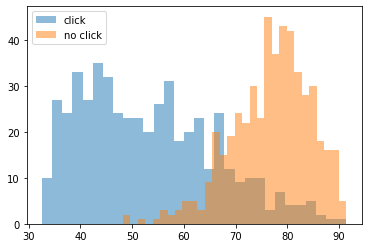

In [6]:
plt.hist(time_click, bins = 30, alpha = 0.5, label = 'click')
plt.hist(time_noclick, bins = 30, alpha = 0.5, label = 'no click')
plt.legend(loc='upper left')
plt.show()

In [7]:
stat, pval = stats.ttest_ind(time_click, time_noclick)


In [8]:
print("T-test results of checking difference between clicked and non-clicked groups on Daily Time spent on Site")
print([stat, pval])

T-test results of checking difference between clicked and non-clicked groups on Daily Time spent on Site
[-35.61636085995531, 5.877384244135832e-180]


In [10]:
cols = ['Daily Time Spent on Site', 'Daily Internet Usage']
daily_data = data[cols]

daily_click = np.log(daily_data[click])
daily_noclick = np.log(daily_data[no_click])

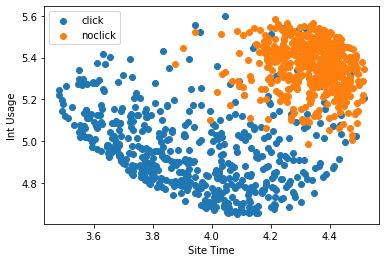

In [11]:
plt.scatter(daily_click[cols[0]], daily_click[cols[1]], marker='o',label='click')
plt.scatter(daily_noclick[cols[0]], daily_noclick[cols[1]], marker='o',label='noclick')
plt.legend(loc='upper left')
plt.xlabel('Site Time')
plt.ylabel('Int Usage')
plt.show()


In [12]:
click_cov = daily_click.cov()
noclick_cov = daily_noclick.cov()

print(click_cov)
print(noclick_cov) 

                          Daily Time Spent on Site  Daily Internet Usage
Daily Time Spent on Site                  0.056608             -0.011578
Daily Internet Usage                     -0.011578              0.036813
                          Daily Time Spent on Site  Daily Internet Usage
Daily Time Spent on Site                  0.010606             -0.001806
Daily Internet Usage                     -0.001806              0.013245


In [13]:
X1 = data["Daily Time Spent on Site"].values
#X1 = X1 - X1.mean()
X2 = data["Daily Internet Usage"].values
#X2 = X2 - X2.mean()
Y = data["Clicked on Ad"].values


In [14]:
with pm.Model() as adv:
    beta = pm.Normal('beta', mu = 0, sd = 1, shape = 3)
    
    mu = pm.Deterministic('mu', beta[0] + beta[1]*X1 + beta[2]*X2)
    L = pm.Deterministic('L', (1 + T.exp(-mu))**(-1))
    
    y = pm.Bernoulli('y', p = L, observed = Y)
    
    trace_adv = pm.sample(2000, tune = 1000, cores = 1)
    

Summary = az.summary(trace_adv, var_names = ['beta'])
print(Summary)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  if __name__ == '__main__':
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 33 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


           mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
beta[0]  11.521  0.546  10.411   12.485  ...     0.01    1439.0    1136.0    1.0
beta[1]  -0.080  0.007  -0.093   -0.067  ...     0.00    1628.0    1399.0    1.0
beta[2]  -0.035  0.003  -0.040   -0.030  ...     0.00    1497.0    1263.0    1.0

[3 rows x 9 columns]


In [19]:
regressor = sklearn.linear_model.LogisticRegression()
X = data[["Daily Time Spent on Site", "Age", "Daily Internet Usage","Male"]]
Y = data["Clicked on Ad"]

In [16]:
perc_gender = data["Male"].value_counts()/len(data["Male"])
print("Percentage of Males and Females in Sample:")
perc_gender.index = ["Male", "Female"]
print(perc_gender)

Percentage of Males and Females in Sample:
Male      0.519
Female    0.481
Name: Male, dtype: float64


In [20]:
corr_X = X.corr()

print(corr_X)

                          Daily Time Spent on Site  ...      Male
Daily Time Spent on Site                  1.000000  ... -0.018951
Age                                      -0.331513  ... -0.021044
Daily Internet Usage                      0.518658  ...  0.028012
Male                                     -0.018951  ...  1.000000

[4 rows x 4 columns]


In [21]:
print("Clicked Proportion of M/F")
print(X[Y == 1]["Male"].value_counts()/sum(Y == 1))
# Again, slight disparity in gender here

print("Non-clicked Proportion of M/F")
print(X[Y == 0]["Male"].value_counts()/sum(Y == 0))

Clicked Proportion of M/F
0    0.538
1    0.462
Name: Male, dtype: float64
Non-clicked Proportion of M/F
1    0.5
0    0.5
Name: Male, dtype: float64


In [22]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X,
                                                                            Y, 
                                                                            test_size = .20,
                                                                            random_state = 0) 

regressor.fit(X_train, Y_train)

LogisticRegression()

In [23]:
print("Beta Coefficients and Intercept")
print("Variables: [Time on Site, Age, Internet Usage, Male]")
print(regressor.coef_)
print(regressor.intercept_)

Beta Coefficients and Intercept
Variables: [Time on Site, Age, Internet Usage, Male]
[[-0.15122578  0.09977007 -0.05878246  0.00195414]]
[17.51655033]


In [24]:
y_pred = regressor.predict(X_test)

print("MSE")
print(sklearn.metrics.mean_squared_error(Y_test, y_pred))
print("R^2")
r2 = sklearn.metrics.r2_score(Y_test, y_pred)
print(r2)

MSE
0.055
R^2
0.7785829307568437


In [25]:
print("Ad Topic Counts for Clicked vs Non-clicked")
print("Clicked:")
print(data[Y == 1]["Ad Topic Line"].value_counts()/sum(Y == 1))

print("Non-Clicked:")
print(data[Y == 0]["Ad Topic Line"].value_counts()/sum(Y == 0))


Ad Topic Counts for Clicked vs Non-clicked
Clicked:
Pre-emptive value-added workforce                0.002
Cross-platform multimedia algorithm              0.002
Synergized hybrid time-frame                     0.002
Down-sized background groupware                  0.002
Assimilated next generation firmware             0.002
                                                 ...  
Reduced multimedia project                       0.002
Future-proofed coherent hardware                 0.002
Function-based context-sensitive secured line    0.002
Exclusive disintermediate Internet solution      0.002
Open-architected needs-based customer loyalty    0.002
Name: Ad Topic Line, Length: 500, dtype: float64
Non-Clicked:
Optional regional throughput                    0.002
Cross-group non-volatile secured line           0.002
Streamlined analyzing initiative                0.002
Up-sized bifurcated capability                  0.002
Synchronized systemic hierarchy                 0.002
           

In [26]:
from sklearn.metrics import classification_report

In [27]:
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       108
           1       0.97      0.91      0.94        92

    accuracy                           0.94       200
   macro avg       0.95      0.94      0.94       200
weighted avg       0.95      0.94      0.94       200

